# Moving average trading

In [1]:
import os
import pandas as pd
import numpy as np
#from tqdm.notebook import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#import seaborn as sns
import ipywidgets as widgets
from ipywidgets import HBox, VBox, TwoByTwoLayout, Label
from ipywidgets import interactive, interactive_output
from ipywidgets import FloatSlider, IntSlider, SelectionSlider, SelectionRangeSlider
from IPython.display import display
import security_comparison as sc
import trading as tra
import trading_plots as trp

from trading_defaults import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Default parameters

In [2]:
TICKER     = 'TDOC'
REFRESH    = True # Download fresh Yahoo data 

START_DATE = '2017-07-15'
END_DATE   = '2021-03-22'

### Data download

In [3]:
raw = tra.load_security(dirname = DATA_DIR, 
                        ticker  = TICKER, 
                        refresh = REFRESH, 
                        period  = DEFAULT_PERIOD,
                        )
security = pd.DataFrame(raw[f'Close_{TICKER}'])
security.rename(columns={f'Close_{TICKER}': "Close"},
                inplace=True)

security

Loading ticker TDOC
[*********************100%***********************]  1 of 1 completed


,Close
Date,
2016-03-24,9.94
2016-03-28,9.50
2016-03-29,9.95
2016-03-30,9.90
2016-03-31,9.60
...,...
2021-03-18,185.43
2021-03-19,190.98
2021-03-22,197.28


#### Setup default start & end dates

In [4]:
# Check dates 
print(tra.get_title_dates(security, START_DATE, END_DATE))
print(tra.get_datetime_dates(security, START_DATE, END_DATE))
print(tra.get_filename_dates(security, START_DATE, END_DATE))

('15-Jul-2017', '22-Mar-2021')
(datetime.datetime(2017, 7, 15, 0, 0), datetime.datetime(2021, 3, 22, 0, 0))
('2017-07-15', '2021-03-22')


## Plotting functions

#### Default plot parameters

In [5]:
color_scheme   = plt.rcParams['axes.prop_cycle'].by_key()['color']
year_month_fmt = mdates.DateFormatter('%b-%y')
title_size     = 14
vline_color    = 'tomato'
gridcolor      = '#ededed'
title_color    = 'dimgrey'
fig_width      = 14
fig_height     = 8

### Main plotting function

In [6]:
def plot_moving(span, fee_pct, buffer, date_range, reactivity=1):
    '''
    Plots price with moving average
    span -> rolling span
    fee -> fee associated with buy/sell action 
    reactivity -> time lag in days after Close (normally = 1)
    '''
    title_date_format = '%d-%b-%Y'
    start = date_range[0]
    end   = date_range[1]
    start_string = start.strftime('%d-%b-%Y')
    end_string   = end.strftime('%d-%b-%Y')
    
    #start = datetime.strptime(start_date, "%Y-%m-%d")
    #end = datetime.strptime(end_date, "%Y-%m-%d")

    # Extract time window
    df = tra.build_strategy(TICKER,
                            security.loc[start:end, :].copy(),
                            span,
                            buffer,
                            INIT_WEALTH,
                           )
    fee  = tra.get_fee(df, fee_pct, ACTIONS)
    hold = tra.get_cumret(df, 'hold', INIT_WEALTH)  # cumulative returns for hold strategy
    ema  = tra.get_cumret(df, 'ema', INIT_WEALTH, fee)  # cumulative returns for EMA strategy

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.plot(df.index, df.Close, linewidth=1, label='Price')
    ax.plot(df.index, df.EMA, linewidth=1, label=f'{span}-days EMA')

    ax.legend(loc='best')
    ax.set_ylabel('Price ($)')
    ax.xaxis.set_major_formatter(year_month_fmt)
    ax.grid(b=None, which='both', axis='both',
             color=gridcolor, linestyle='-', linewidth=1)

    title  = f'{TICKER} | '
    title += f'{start.strftime(title_date_format)} - {end.strftime(title_date_format)}\n'
    title += f'EMA payoff={ema:.2%} (Hold={hold:.1%}) | '
    title += f'{span}-day rolling mean | {buffer:.2%} buffer'
    ax.set_title(title, fontsize=title_size, color=title_color)

    trp.plot_arrows(ax, df, ACTIONS, colors)
    trp.save_figure(PLOT_DIR, f'{TICKER}_{start_string}_{end_string}')
    return df

In [18]:
# Finds optimal span for a given buffer size
def plot_span_range(buffer, n_values, fee_pct, date_range, extension='png'):
    emas = []
    span_range = [MIN_SPAN, MAX_SPAN]
    spans = np.arange(span_range[0],
                      span_range[1] + 1)
    start = date_range[0]
    end   = date_range[1]
    start_string = start.strftime('%d-%b-%Y')
    end_string   = end.strftime('%d-%b-%Y')

    for i, span in enumerate(spans):
        df = tra.build_strategy(TICKER,
                              security.loc[start:end, :].copy(),
                              span,
                              buffer,
                              INIT_WEALTH,
                             )
        fee = tra.get_fee(df, fee_pct, ACTIONS)
        ema = tra.get_cumret(df, 'ema', INIT_WEALTH, fee)
        emas.append(ema)
        if i == 0:
            hold = tra.get_cumret(df, 'hold', INIT_WEALTH)
    df = pd.DataFrame(data=[spans, emas]).T
    df.columns = ['span', 'ema']
    
    max_val = df['ema'].max()
    min_val = df['ema'].min()

    # Plot
    fig, ax     = trp.plot_setup(df, target='span', xlabel='rolling mean span (days)')
    largest_idx = trp.plot_max_values(df, ax, n_values, max_val, min_val, 'integer')

    title  = f'{TICKER} | {start_string} - {end_string}\n'
    title += f'EMA max payoff={max_val:.2%} (hold={hold:.2%}) | '
    title += f'opt span={df.iloc[largest_idx[0]][0]:.0f} days | '
    title += f'{buffer:.2%} buffer'
    ax.set_title(title, fontsize=title_size, color=title_color)

    # save plot to file
    trp.save_figure(PLOT_DIR, f'{TICKER}_{start_string}_{end_string}_spans')

In [19]:
# Finds optimal buffer size for a given rolling-window span
def plot_buffer_range(span, n_values, fee_pct, date_range, extension='png'):
    buffer_range = [MIN_BUFF, MAX_BUFF]
    buffers = np.linspace(buffer_range[0],
                          buffer_range[1],
                          101)
    start = date_range[0]
    end   = date_range[1]
    start_string = start.strftime('%d-%b-%Y')
    end_string   = end.strftime('%d-%b-%Y')
    
    emas = []
    for i, buffer in enumerate(buffers):
        df = tra.build_strategy(TICKER,
                              security.loc[start:end, :].copy(),
                              span,
                              buffer,
                              INIT_WEALTH,
                             )
        if i == 0:
            hold = tra.get_cumret(df, 'hold', INIT_WEALTH)
        fee = tra.get_fee(df, fee_pct, ACTIONS)
        emas.append(tra.get_cumret(df, 'ema', INIT_WEALTH, fee))
        
    df = pd.DataFrame(data=[buffers, emas]).T
    df.columns = ['buffer', 'ema']
    
    max_val = df['ema'].max()
    min_val = df['ema'].min()

    # Plot
    fig, ax     = trp.plot_setup(df, target='buffer', xlabel='buffer size (% around EMA)')
    largest_idx = trp.plot_max_values(df, ax, n_values, max_val, min_val, 'percent')

    ax = trp.build_title(ax, 
                         TICKER, 
                         start_string, end_string, 
                         max_val, hold, 
                         span, df.iloc[largest_idx[0]][0],
                        )
    
    #title  = f'{TICKER} | {start_string} - {end_string}\n'
    #title += f'EMA max payoff={max_val:.2%} (hold={hold:.2%}) | '
    #title += f'{span}-day mean | '
    #title += f'opt buffer={df.iloc[largest_idx[0]][0]:.2%}' 
    #ax.set_title(title, fontsize=title_size, color=title_color)
 
    trp.save_figure(PLOT_DIR, f'{TICKER}_{start_string}_{end_string}_buffers')

def build_ema_map(start, end, n_maxima, fee_pct):
    ''' 
    Builds a 2D numpy array of EMAs as a function of span and buffer
    '''
    n_buffers  = 101
    
    # define rolling window span range
    spans = np.arange(MIN_SPAN,
                      MAX_SPAN + 1, 
                      step = 1)
    
    # define buffer range
    buffers = np.linspace(MIN_BUFF,
                          MAX_BUFF,
                          n_buffers,)
    
    # Initialize EMA returns 
    emas = np.zeros((spans.shape[0], buffers.shape[0]), dtype=np.float64)
    
    # Fill EMAS for all span/buffer combinations
    tqdm_desc = f'Outer Level / {MAX_SPAN - MIN_SPAN + 1}'
    for i, span in tqdm(enumerate(spans), desc=tqdm_desc):
        for j, buffer in enumerate(buffers):
            df  = tra.build_strategy(TICKER,
                                   security.loc[start:end, :].copy(),
                                   span,
                                   buffer,
                                   INIT_WEALTH,
                                  ) 
            emas[i][j] = tra.get_cumret(df, 'ema', 
                                        INIT_WEALTH, 
                                        tra.get_fee(df, fee_pct, ACTIONS))
            if i == 0 and j == 0:
                hold = tra.get_cumret(df, 'hold', INIT_WEALTH)
    
    return spans, buffers, emas, hold
    

Outer Level / 56: 56it [03:36,  3.86s/it]


Max EMA 0=225.63%: 11-days buffer=0.81% (hold=464.46%)
Max EMA 1=215.60%: 44-days buffer=2.88% (hold=464.46%)
Max EMA 2=214.10%: 37-days buffer=1.77% (hold=464.46%)
Max EMA 3=213.11%: 31-days buffer=2.10% (hold=464.46%)
Max EMA 4=213.11%: 31-days buffer=2.13% (hold=464.46%)
Max EMA 5=213.11%: 31-days buffer=2.16% (hold=464.46%)
Max EMA 6=211.72%: 11-days buffer=0.78% (hold=464.46%)
Max EMA 7=210.88%: 43-days buffer=2.91% (hold=464.46%)
Max EMA 8=210.88%: 43-days buffer=2.94% (hold=464.46%)
Max EMA 9=210.88%: 44-days buffer=2.91% (hold=464.46%)


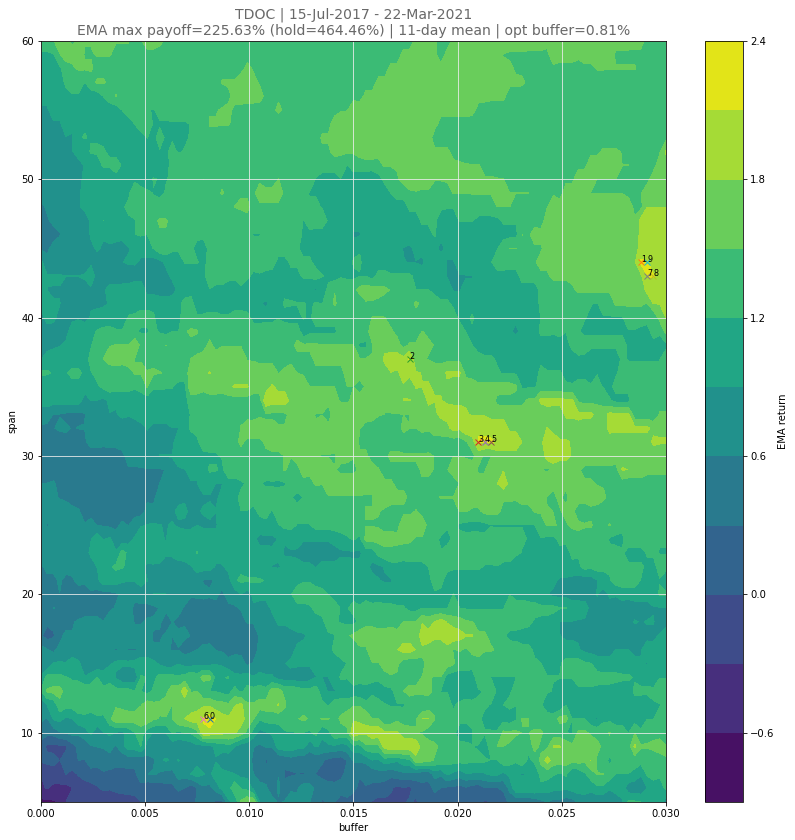

In [20]:
# Contour plot of EMA for all window span/buffer size combinations
def plot_buffer_span_contours(fee_pct=FEE_PCT):
    '''
    Contour plot of EMA as a function of rolling-window span & buffer
    '''
    fig_size   = (14, 14)
    n_contours = 10 # number of contours
    n_maxima   = 10 # number of maximum points to plot
    #n_buffers  = 101

    # Get start & end dates in various fomats
    start, end             = tra.get_datetime_dates(security, START_DATE, END_DATE)
    start_title, end_title = tra.get_title_dates(security, START_DATE, END_DATE)
    start_name, end_name   = tra.get_filename_dates(security, START_DATE, END_DATE)
    
    spans, buffers, emas, hold = tra.build_ema_map(TICKER, security, start, end)
    
    # Plot
    fig, ax = plt.subplots(figsize=fig_size)
    plt.contourf(buffers, spans, emas, 
                 levels=n_contours, 
                 cmap='viridis', 
                 )
    plt.colorbar(label='EMA return')
            
    # Plot maxima points 
    max_ema, max_span, max_buff = trp.plot_maxima(emas, 
                                                  spans, 
                                                  buffers, 
                                                  hold, 
                                                  ax, 
                                                  n_maxima)
        
    # Axis labels
    ax.set_xlabel('buffer')
    ax.set_ylabel('span')
    
    # Build title
    title  = f'{TICKER} | {start_title} - {end_title}\n'
    title += f'EMA max payoff={max_ema:.2%} (hold={hold:.2%}) | '
    title += f'{max_span:.0f}-day mean | '
    title += f'opt buffer={max_buff:.2%}'
    ax.set_title(title, fontsize=title_size, color=title_color)
    
    plt.grid(b=None, which='major', axis='both', color=gridcolor)
    trp.save_figure(PLOT_DIR, f'{TICKER}_{start_name}_{end_name}_contours')
    plt.show()
    
plot_buffer_span_contours()
    

### Interactive plots

#### Widget defaults

In [21]:
string_style = {'description_width': 'initial', 
                'handle_color':      'lawngreen'}

start_period, end_period = tra.get_datetime_dates(security, START_DATE, END_DATE)
dates   = pd.date_range(start_period, end_period, freq='D')
options = [(date.strftime(' %d/%m/%Y'), date) for date in dates]
index   = (0, len(options)-1)

# Tx/broker's fee
min_fee     = 0.0
max_fee     = .01
delta_fee   = .0005
default_fee = FEE_PCT

# of days for running mean
min_span     = MIN_SPAN
max_span     = MAX_SPAN
delta_span   = 1
default_span = 20

# buffer around EMA
min_buffer     = MIN_BUFF
max_buffer     = MAX_BUFF
delta_buffer   = .0001
default_buffer = .01

# number of maxima
max_value     = 15
default_value = 12

#start_date = '2017-07-15'

#### Interactive returns for window span

In [22]:
# Mean window span range optimizer interactive

buffer_slider = FloatSlider(min=min_buffer,
                            max=max_buffer,
                            step=delta_buffer,
                            value=default_buffer,
                            style=string_style,
                            continuous_update=False,
                            description='Buffer (%):',
                            disabled=False,
                            readout=True,
                            readout_format='.2%',
                            layout      = {'width': '250px'},
                           )

max_values_slider = SelectionSlider(options=[x for x in range(0, max_value+1)],
                                    value=default_value,
                                    description='Number of maxima:',
                                    style=string_style,
                                    disabled=False,
                                    continuous_update=False,
                                    readout=True,
                                    readout_format='d',
                                    layout      = {'width': '500px'},
                                   )

fee_slider = FloatSlider(min=min_fee,
                         max=max_fee,
                         step=delta_fee,
                         value=default_fee,
                         description='Fees (%):',
                         style=string_style,
                         disabled=False,
                         continuous_update=False,
                         readout=True,
                         readout_format='.2%',
                         layout      = {'width': '250px'},
                        )

date_range_slider = SelectionRangeSlider(options = options,
                                         index   = index,
                                         description = 'Period:',
                                         orientation = 'horizontal',
                                         style       = string_style,
                                         layout      = {'width': '500px'}
                                        )

ui  = widgets.HBox([buffer_slider, fee_slider, max_values_slider])
out = widgets.interactive_output(plot_span_range,
                                 {'buffer': buffer_slider,
                                  'n_values': max_values_slider,
                                  'fee_pct': fee_slider,
                                  }
                                 )

out = interactive_output(plot_span_range,
                         {'buffer'      : buffer_slider,
                          'n_values'  : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

ui = TwoByTwoLayout(top_left     = fee_slider,
                    top_right    = date_range_slider,
                    bottom_left  = buffer_slider,
                    bottom_right = max_values_slider,
                    )

display(ui, out)

TwoByTwoLayout(children=(FloatSlider(value=0.004, continuous_update=False, description='Fees (%):', layout=Lay…

Output()

#### Interactive returns for buffer size

In [23]:
# Buffer range optimizer interactive 
span_slider = IntSlider(min=min_span,
                        max=max_span,
                        step=delta_span,
                        value=default_span,
                        description='Mean span:',
                        style=string_style,
                        disabled=False,
                        continuous_update=False,
                        readout=True,
                        readout_format='d',
                        layout = {'width': '250px'},
                       )

max_values_slider = SelectionSlider(options=[x for x in range(0, max_value+1)],
                                    value=default_value,
                                    description='Number of maxima:',
                                    style=string_style,
                                    disabled=False,
                                    continuous_update=False,
                                    readout=True,
                                    readout_format='d',
                                    layout = {'width': '500px'},
                                   )

fee_slider = FloatSlider(min=min_fee,
                         max=max_fee,
                         step=delta_fee,
                         value=default_fee,
                         description='Fees (%):',
                         style=string_style,
                         disabled=False,
                         continuous_update=False,
                         readout=True,
                         readout_format='.2%',
                         layout = {'width': '250px'},
                        )

date_range_slider = SelectionRangeSlider(options = options,
                                         index   = index,
                                         description = 'Period:',
                                         orientation = 'horizontal',
                                         style  = string_style,
                                         layout = {'width': '500px'},
                                        )

out = interactive_output(plot_buffer_range,
                         {'span'      : span_slider,
                          'n_values'  : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

ui = TwoByTwoLayout(top_left     = fee_slider,
                    top_right    = date_range_slider,
                    bottom_left  = span_slider,
                    bottom_right = max_values_slider,
                    )

display(ui, out)

TwoByTwoLayout(children=(FloatSlider(value=0.004, continuous_update=False, description='Fees (%):', layout=Lay…

Output()

#### Interactive buffer-span

In [24]:
# Buffer-span interactive plot

fee_slider = FloatSlider(min=min_fee,
                         max=max_fee,
                         step=delta_fee,
                         value=default_fee,
                         description='Fees (%):',
                         style=string_style,
                         disabled=False,
                         continuous_update=False,
                         readout=True,
                         readout_format='.2%',
                         layout={'width': '250px'},
                         )

span_slider = IntSlider(min=min_span,
                        max=max_span,
                        step=delta_span,
                        value=default_span,
                        description='Mean span:',
                        style=string_style,
                        disabled=False,
                        continuous_update=False,
                        readout=True,
                        readout_format='d',
                        layout={'width': '250px'},
                        )

buffer_slider = FloatSlider(min=min_buffer,
                            max=max_buffer,
                            step=delta_buffer,
                            value=default_buffer,
                            style=string_style,
                            continuous_update=False,
                            description='Buffer (%):',
                            disabled=False,
                            readout=True,
                            readout_format='.2%',
                            layout={'width': '500px'},
                            )

# Date range slider
date_range_slider = SelectionRangeSlider(options = options,
                                         index   = index,
                                         description = 'Period:',
                                         orientation = 'horizontal',
                                         style       = string_style,
                                         layout      = {'width': '500px'}
                                        )


out = interactive_output(plot_moving,
                         {'span'      : span_slider,
                          'buffer'    : buffer_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

ui = TwoByTwoLayout(top_left     = fee_slider,
                    top_right    = date_range_slider,
                    bottom_left  = span_slider,
                    bottom_right = buffer_slider,
                    )

display(ui, out)

TwoByTwoLayout(children=(FloatSlider(value=0.004, continuous_update=False, description='Fees (%):', layout=Lay…

Output()